In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import os
import sys; sys.path.append('../')
import numpy as np
from numpy.random import default_rng
from numpy.fft import fft, ifft
from findiff import FinDiff

import scipy.io as sio
import pysindy as ps
from PDE_FIND import build_linear_system, print_pde, TrainSTRidge
from robust_PDE_FIND import RobustPCA
from best_subset import *
from UBIC import *

from sklearn.decomposition import PCA, TruncatedSVD
# from skimage.restoration import denoise_wavelet, estimate_sigma

from pydmd import DMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary, plot_modes_2D
from pydmd.preprocessing.hankel import hankel_preprocessing

def evaluate_coefficients(prediected_coeffs):
    GROUND = np.array([0.1, -1])
    errs = 100*np.abs(GROUND-np.array(prediected_coeffs).flatten())/np.abs(GROUND)
    return errs.mean(), errs.std()

Sklearn's version: 1.2.2


#### Load data

In [2]:
data = sio.loadmat('../Datasets/burgers.mat')
u = (data['usol']).real
x = (data['x'][0]).real
t = (data['t'][:,0]).real
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

#### Visualization

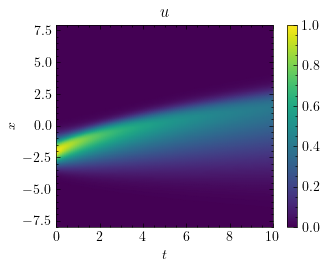

In [3]:
with plt.style.context(['science']):
    ufig, uax = plt.subplots()
    contour = uax.pcolormesh(t, x, u, shading='gouraud')
    uax.set_xlabel("$t$")
    uax.set_ylabel("$x$")
    uax.set_title("$u$")
    cbar = ufig.colorbar(contour)
    # ufig.savefig("../Figures/burgers.png", dpi=300)
    plt.show()

#### Add noise

In [4]:
print("----- Clean -----")
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
rhs_des = rhs_des[1:]
R = R[:, 1:].real; Ut = Ut.real
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

print()

print("----- Add 30% noise -----")
np.random.seed(0)
noise_lv = float(30)
print(noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
un = u + noise
np.mean(noise), np.std(noise), np.max(noise), np.min(noise)

Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly',
                                       deg_x = 4, deg_t = 4, 
                                       width_x = 10, width_t = 10)
rhs_des = rhs_des[1:]
Rn = Rn[:, 1:].real; Utn = Utn.real
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

----- Clean -----
STLSQ model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
l0_penalty: 1.6123253173828125
PDE derived using STRidge
u_t = (-1.000403 +0.000000i)uu_{x}
    + (0.100145 +0.000000i)u_{xx}
   

----- Add 30% noise -----
30.0
l0_penalty: 1.93969921875
PDE derived using STRidge
u_t = (-0.775461 +0.000000i)uu_{x}
   


In [5]:
print(np.linalg.norm(u-un, ord='fro'), np.linalg.norm(u-un, ord=np.inf))

8.673577639876537 5.298318588581592


#### Use the precomputed denoised variable given by the K-SVD

In [6]:
denoised = True
if denoised: 
    denoised_un = np.load("../Examples/denoised_files/burgers_dictlearn_denoised30_components32_8x8.npy")
    un = denoised_un
    
    ### PCA ###
#     target_percentage = 99.5
#     summ = 0.0
#     n_components = 0
#     sigma = PCA(n_components=un.shape[-1]).fit(un).explained_variance_ratio_
#     for s in sigma:
#         summ += s
#         n_components += 1
#         if summ > target_percentage/100:
#             break
#     print(n_components, summ)
#     assert n_components < len(sigma)
#     pca = PCA(n_components=un.shape[-1]).fit(un)
#     pca_un = pca.inverse_transform(pca.transform(un))
#     un = pca_un
    
    ### SVD ###
#     target_percentage = 99.5
#     summ = 0.0
#     n_components = 0
#     U, Sigma, V = np.linalg.svd(un, full_matrices=False); V = V.T
#     sigma = Sigma/sum(Sigma)
#     for s in sigma:
#         summ += s
#         n_components += 1
#         if summ > target_percentage/100:
#             break
#     print(n_components, summ)
#     assert n_components < len(Sigma)
#     svd_un = U[:, 0:n_components].dot(np.diag(Sigma[0:n_components]).dot(V[:,0:n_components].T))
#     un = svd_un
    
    ### Wavelet denoising ###
#     wavelet_un = denoise_wavelet(un, channel_axis=None, convert2ycbcr=False, 
#                                  sigma=estimate_sigma(un, channel_axis=None, average_sigmas=True), 
#                                  method='BayesShrink', mode='soft', rescale_sigma=True)
#     un = wavelet_un
    
    ### Robust PCA ###
#     rpca_lam = 0.1
#     un, _ = RobustPCA(un, rpca_lam)
    
    ### FFT ###    
#     def remove_f(uu, percent):
#         if percent <= 0: return uu
#         PSD = (uu*np.conj(uu))/np.prod(uu.shape)
#         PSD = PSD.real
#         mask = (PSD>np.percentile(PSD, percent)).astype(np.float32)
#         return uu*mask
#     remove_percent = 50
#     un = ifft(remove_f(fft(un), remove_percent)).real
    
    print(np.linalg.norm(u-un, ord='fro'), np.linalg.norm(u-un, ord=np.inf))

2.858361587460368 2.274811883362282


#### Applying best-subset regression on the weak formulation

In [7]:
poly_deg = None; diff_order = 2
differentiation_method = ps.FiniteDifference; differentiation_kwargs = {}
kwargs = {'copy_X':True, 'normalize_columns':False}

weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                 function_names=[lambda x: x, lambda x: x + x], 
                                 derivative_order=diff_order, p=diff_order, 
                                 spatiotemporal_grid=XT, 
                                 include_bias=False, is_uniform=True, K=10000, # new random K points in every calls to the ps.WeakPDELibrary
                                 cache=True
                                )

X_pre, y_pre, fns = ps_features(un, dt, weak_pde_lib, kwargs)

differentiation method or differentiation_kwargs is not implemented in feature_library.


In [8]:
optimizer_name = "miosr" # "l0bnb", "miosr"
assert (optimizer_name == "l0bnb") or (optimizer_name == "miosr")
if optimizer_name == "l0bnb":
    optimizer = L0BNB(max_nonzeros=2, lam=1e-3, is_normal=True, normalize_columns=False)
elif optimizer_name == "miosr":
    optimizer = ps.MIOSR(target_sparsity=2, normalize_columns=True, regression_timeout=100)
    
n_ensemble_models = 50
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                 differentiation_method=differentiation_method,
                 cache=True,
                 feature_names=['u'])
model.fit(np.expand_dims(un, -1), t=dt)
print(model.get_feature_names())
# print found pde
print_pde(model.get_coef_list()[np.argmin(np.sum((np.squeeze(np.tensordot(X_pre, np.array(model.get_coef_list()).T, axes=([-1], [0])), axis=1)-y_pre)**2, axis=0))].reshape(-1,1), model.get_feature_names())

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04
['u', 'uu', 'u_1', 'u_11', 'uu_1', 'uuu_1', 'uu_11', 'uuu_11']
u_t = (0.099884 +0.000000i)u_11
    + (-0.994552 +0.000000i)uu_1
   


In [9]:
best_subsets = [tuple(np.where(abs(brute_force(X_pre, y_pre, support_size=i).flatten())>0)[0]) 
                for i in range(1, X_pre.shape[1]+1)]

#### Model selection by the UBIC (Algorithm 1)

In [10]:
tau = 3
verbose = True
scale = np.log(len(y_pre))
# scale = 1 <- generalized UBIC
per = 75 # 75, 85, 95

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
print(np.argmin(b_bics)+1)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and (diff_bic > 0 or imp <= thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp >= thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 10)
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
    
last_lam = round(last_lam, 10)
if last_lam >=0: last_lam = abs(last_lam)
last_lam, last_ubic, last_bc, best_bc

5
threshold: 0.04694010542508798
max_lam: 3.9246865661785173
1 <---> 1 inf
1 <---> 1 inf
1 <---> 1 inf


(0.0,
 array([-65207.60451301, -77430.2372336 , -77411.3528236 , -77409.46120388,
        -77403.12069442, -77361.11989002, -77334.10458441, -77150.49229673]),
 1,
 1)

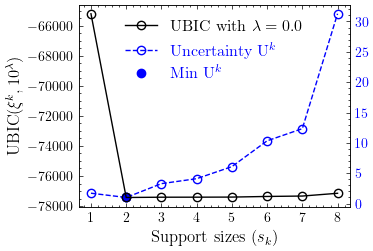

In [11]:
complexity_axis = [len(bs) for bs in best_subsets]
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
#     ax.annotate('$(u_{xx}, uu_{x})\checkmark$', fontsize=16, 
#                  xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
#                  xytext=(complexity_axis[best_bc]+0.1, last_ubic[best_bc]+4000), 
#                  arrowprops={'arrowstyle': '->'})
    
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {abs(round(last_lam, 2))}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='upper center', fontsize=11.5)
    
    # plt.savefig("burgers_wavelet_ubic.pdf")
    plt.show()

#### Percent coefficient error

In [12]:
evaluate_coefficients(np.linalg.lstsq(X_pre[:, best_subsets[best_bc]], 
                                      y_pre, rcond=None)[0].flatten())

(0.9107969701290103, 0.3772757947444888)

In [13]:
# No denoising: 8.673577639876537 5.298318588581592 
# rksvd: 2.858361587460368 2.274811883362282 | (0.9107969701290103, 0.3772757947444888)
# svd n_comp=74: 8.2830942877307 4.990897588534944 | (0.4377375780166351, 0.18439574973366096)
# svd n_comp=86: 8.51040101515912 5.163254362785331 | (0.5747929503770288, 0.03141691852627804)
# svd n_comp=99 (99.5): 8.660746565852696 5.324954980348864 | (0.770910494195949, 0.1326679698575986)
# pca n_comp=3: 4.754262017591448 5.675915023400061 | - 3 selected
# pca n_comp=22: 5.539849551837206 3.837241763152806 | (1.4805624720730992, 1.36812501749769)
# pca 99.5: 8.673577639876537 5.298318588581601 | (0.789937132828003, 0.1534230910104767)
# Robust PCA: 7.445189944826652 4.617636462159813 | (1.9538318222493618, 1.7621799177316084)
# wavelet: 2.5287134283765695 2.1318082910253775 | (2.4942281074157746, 1.5133039078568222)

In [14]:
# FFT_{10}: 5.226547898222989 5.066573466223977 | (1.6110419451166242, 1.0472379899339952)
# FFT_{25}: 6.753362788411607 5.163727170937074 | (1.201034558494282, 0.8659130290210453)
# FFT_{50} 7.9994861519105465 5.248014032576636 | (0.7640200277319542, 0.08523892373680231)

#### Subspaces: Fourier, POD, DMD

In [15]:
from tools import *
from derivative import dxdt

#### Strategy I

In [16]:
fft_percent = 0
n_modes = 20
acc = 8
include_bias = False

# uu = u.copy()
uu = un.copy()
# uu = POD(un, n_modes)
# uu = ROM(un, t, n_modes, "DMD")
# uu = ROM(un, t, n_modes, "BOPDMD", num_trials=0, tol=None)

# automate this...
# d_dx = FinDiff(0, dx, 1, acc=acc); u_x = d_dx(uu)
# d_dxx = FinDiff(0, dx, 2, acc=acc); u_xx = d_dxx(uu)
# d_dxxx = FinDiff(0, dx, 3, acc=acc); u_xxx = d_dxxx(uu)
# d_dt = FinDiff(1, dt, 1, acc=acc); u_t = d_dt(uu)

# automate this...
diff_spec = {"kind":"kalman", "alpha":5e-2}
d_dt = lambda _: dxdt(_, t, axis=1, **diff_spec)
d_dx = lambda _: dxdt(_, x, axis=0, **diff_spec)
u_x = d_dx(uu)
u_xx = d_dx(u_x)
u_xxx = d_dx(u_xx)
u_t = d_dt(uu)
poly_deg = 2;
phi1 = [u**i for i in range(0, poly_deg+1)]; phi1_names = ["", "u", "u^{2}"]
phi2 = [u_x, u_xx]; phi2_names = ["u_{x}", "u_{xx}"]
# phi2 = [u_x, u_xx, u_xxx]; phi2_names = ["u_{x}", "u_{xx}", "u_{xxx}"]
phi = phi1.copy(); phi_names = phi1_names.copy()
phi.extend(phi2); phi_names.extend(phi2_names)
phi.extend([p1*p2 for p2 in phi2 for p1 in phi1[1:]])
phi = np.array(phi)
phi_names.extend([p1+p2 for p2 in phi2_names for p1 in phi1_names[1:]])
fft_phi = [remove_f(np.fft.fft(_, axis=-1), fft_percent, inverse=False) for _ in phi]
fft_u_t = remove_f(np.fft.fft(u_t, axis=-1), fft_percent, inverse=False)

Theta_grouped = np.moveaxis(phi, 0, -1)
Ut_grouped = np.expand_dims(u_t, -1)
rhs_des = phi_names
fft_Theta_grouped = np.moveaxis(fft_phi, 0, -1)
fft_Ut_grouped = np.expand_dims(fft_u_t, -1)

del phi1, phi2, phi1_names, phi2_names

X_fft, y_fft = fft_Theta_grouped.reshape(-1, len(phi_names)), fft_Ut_grouped.reshape(-1, 1)

print("PDE derived using STRidge")
print_pde(TrainSTRidge(X_fft, 
                       y_fft, 
                       10**-5, 1), 
          phi_names)

if not include_bias:
    X_fft = X_fft[:, 1:]
    phi_names = phi_names[1:]

PDE derived using STRidge
l0_penalty: 0.204782897533337
u_t = (0.081013 -0.001614i)u^{2}
    + (-0.011271 -0.000472i)u_{x}
    + (0.076032 +0.000831i)u_{xx}
    + (-1.527792 +0.005537i)uu_{x}
    + (0.989069 -0.005924i)u^{2}u_{x}
    + (0.343262 -0.009121i)uu_{xx}
    + (-0.235622 +0.010276i)u^{2}u_{xx}
   


In [17]:
best_ws = []
w_distance = []
for com in range(1, len(best_subsets)+1):
    w = np.zeros((X_pre.shape[-1], 1))
    eff_indices = best_subsets[com-1]
    # V1 -> kalman_alpha should be tuned so that V1 close to V2
    w1 = np.linalg.lstsq(X_fft[:, eff_indices], y_fft, rcond=None)[0]
    w2 = np.linalg.lstsq(X_pre[:, eff_indices], y_pre, rcond=None)[0]
    w_distance.append((abs(w1-w2)**2).mean())
    w[eff_indices, :] = w2
    best_ws.append(w)
best_ws = np.hstack(best_ws)
print(np.mean(w_distance))
# 29.285422102144498
evaluate_coefficients(np.linalg.lstsq(X_fft[:, best_subsets[1]], 
                                      y_fft, rcond=None)[0].real.flatten())

0.042596941446707205


(20.923788206762445, 16.4513950482403)

[106390.77345220966, 106386.78311826894, 106400.62462202128, 106410.2242504328, 106423.48802878153, 106437.08997017448, 106447.3864816738, 106457.68085725636]
2


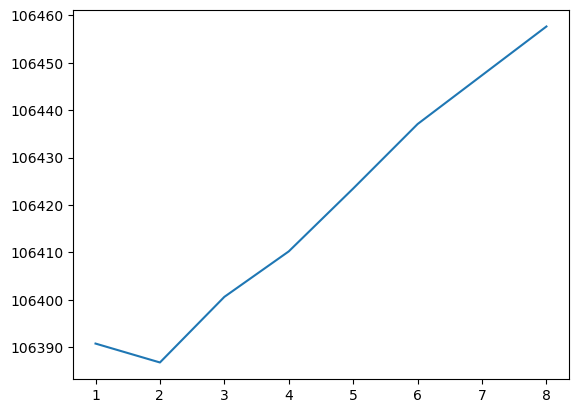

In [18]:
b_bics = []
rss_list = []
nfft = None
ground = periodogram_f(fft_Ut_grouped[:, :, 0], nfft=nfft).reshape(-1, 1)
for com in range(1, len(best_subsets)+1):
    w = best_ws[:, com-1:com]
    pred = X_fft@w
    pred = periodogram_f(ifft(pred.reshape(uu.shape)), nfft=nfft).reshape(-1, 1)
    rss = 2*np.pi*sum_squared_residuals(pred, ground)/len(ground)
    rss_list.append(rss)
    
min_epsilon = 1e-5
epsilon = max(min_epsilon, 10**(convert_to_scientific_notation(max(rss_list))[-1]))
epsilon = 1e-5

for com in range(1, len(best_subsets)+1):
    w = best_ws[:, com-1:com]
    pred = X_fft@w
    pred = periodogram_f(ifft(pred.reshape(uu.shape)), nfft=nfft).reshape(-1, 1)
    # different window types may be used...
    b_bics.append(mbic(pred, ground, com, epsilon))
    
print(b_bics)
print(np.argmin(b_bics)+1)
plt.plot(complexity_axis, b_bics); plt.show()

In [19]:
tau = 3
verbose = True
scale = np.log(len(y_fft))
# scale = 1 <- generalized UBIC
per = 75 # 75, 85, 95

post_means, _, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_fft@post_means

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(periodogram_f(ifft(predictions[:, k:k+1].reshape(uu.shape)), nfft=nfft).reshape(-1, 1), 
                                          ground, epsilon))-np.log(len(y_fft))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_fft), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_fft), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if min(last_bc, now_bc) > 0:
        if (diff_com > 0 and (diff_bic > 0 or imp <= thres)) or \
            (diff_com < 0 and diff_bic > 0 and imp >= thres):
            break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 10)
    last_ubic = now_ubic
    last_bc = now_bc
    
last_lam = round(last_lam, 10)
if last_lam >= 0: last_lam = abs(last_lam)
last_lam, last_ubic, last_bc

threshold: 3.7506390932573066e-05
max_lam: 4.019815294379951
1 <---> 1 inf
1 <---> 1 inf
1 <---> 1 inf


(0.0,
 array([106408.10208269, 106396.94341623, 106433.97303961, 106451.86075353,
        106485.31486185, 106542.11234872, 106572.77190163, 106775.46756682]),
 1)

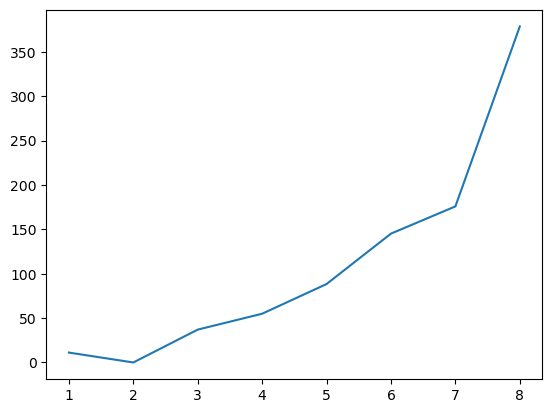

In [20]:
plt.plot(complexity_axis, last_ubic-min(last_ubic)); plt.show()

#### Strategy II (easier)

5


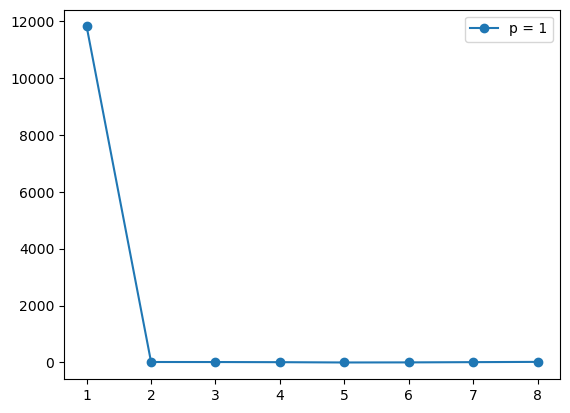

In [21]:
for n_pow in ([1]):
    b_bics = []
    rss_list = []
    for com in range(1, len(best_subsets)+1):
        rss = 2*np.pi*sum_squared_residuals(X_pre@best_ws[:, com-1:com]**n_pow, 
                                            y_pre**n_pow)/len(ground)
        rss_list.append(rss)
    min_epsilon = 1e-5
    epsilon = max(min_epsilon, 10**(convert_to_scientific_notation(max(rss_list))[-1]))
    epsilon = 1e-5

    # epsilon = 0
    for com in range(1, len(best_subsets)+1):    
        b_bics.append(mbic((X_pre@best_ws[:, com-1:com])**n_pow, 
                           y_pre**n_pow, com, epsilon=epsilon))
    # print(b_bics)
    print(np.argmin(b_bics)+1)
    plt.plot(complexity_axis, b_bics-min(b_bics), '-o', label=f'p = {n_pow}')
plt.legend()
plt.show()

In [22]:
tau = 3
verbose = True
scale = np.log(len(y_pre))
# scale = 1 <- generalized UBIC
per = 75 # 75, 85, 95

post_means, _, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1]**n_pow, y_pre**n_pow, epsilon))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if min(last_bc, now_bc) > 0:
        if (diff_com > 0 and (diff_bic > 0 or imp <= thres)) or \
            (diff_com < 0 and diff_bic > 0 and imp >= thres):
            break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 10)
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
    
last_lam = round(last_lam, 10)
if last_lam >=0: last_lam = abs(last_lam)
last_lam, last_ubic, last_bc, best_bc

threshold: 0.04542295849449291
max_lam: 3.921255080745449
1 <---> 1 inf
1 <---> 1 inf
1 <---> 1 inf


(0.0,
 array([-65024.23837261, -76820.77684883, -76801.2212354 , -76798.45111583,
        -76790.85442839, -76748.47540893, -76721.42122639, -76537.80832369]),
 1,
 1)

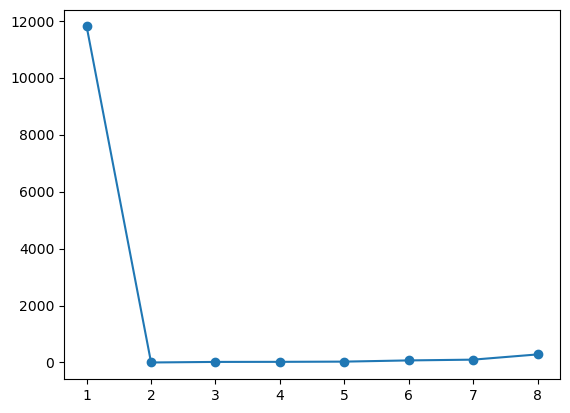

In [23]:
plt.plot(complexity_axis, last_ubic-min(last_ubic), '-o'); plt.show()

In [24]:
import metric_learn
from sklearn.manifold import TSNE
from scipy.stats import wilcoxon

def plot_tsne(X, y, colormap=plt.cm.Paired):
    plt.figure(figsize=(8, 6))

    # clean the figure
    plt.clf()

    tsne = TSNE()
    X_embedded = tsne.fit_transform(X)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap=colormap)

    plt.xticks(())
    plt.yticks(())

    plt.show()
    
# plot_tsne(X_pre, y_pre.flatten(), plt.cm.Oranges)

In [25]:
# #terms: 1
# 2.5328294526433704e-05 8.600291e-05
# #terms: 2
# 2.5554470336424816e-05 2.5326382e-05

# for com in range(1, len(best_subsets)):
#     print("#terms:", com)
#     base_indices = best_subsets[com-1]
#     X_org = X_pre[:, base_indices]
#     baseline_perf = mean_squared_error(y_pre, 
#                                        X_org@np.linalg.lstsq(X_org, y_pre, rcond=None)[0])
#     mlkr = metric_learn.MLKR(n_components=len(base_indices))
#     X_mlkr = mlkr.fit_transform(X_pre[:, best_subsets[com]], y_pre)
#     new_perf = mean_squared_error(y_pre, X_mlkr@np.linalg.lstsq(X_mlkr, y_pre, rcond=None)[0])
#     print(new_perf, baseline_perf)
#     if new_perf >= baseline_perf:
#         break
    
# # X_mlkr1 = mlkr.fit_transform(X_pre[:, best_subsets[0]], y_pre) 
# # print(((y_pre-X_mlkr1@np.linalg.lstsq(X_mlkr1, y_pre)[0])**2).mean()) # 8.600291239174182e-05
# # mlkr = metric_learn.MLKR(n_components=2)
# # X_mlkr2 = mlkr.fit_transform(X_pre[:, best_subsets[1]], y_pre)
# # print(((y_pre-X_mlkr2@np.linalg.lstsq(X_mlkr2, y_pre)[0])**2).mean()) # 2.532638318665256e-05
# # mlkr = metric_learn.MLKR(n_components=2)
# # X_mlkr3 = mlkr.fit_transform(X_pre[:, best_subsets[2]], y_pre)
# # print(((y_pre-X_mlkr3@np.linalg.lstsq(X_mlkr3, y_pre)[0])**2).mean()) # 2.55604526669033e-05

In [26]:
n_learn = 2000; max_iterations = 30
left_indices = set(np.arange(len(X_pre)))
it = 0
now_com = 1
base_performance = []
new_performance = []
while len(left_indices) >= n_learn and it < max_iterations:
    choosen_indices = np.random.choice(sorted(left_indices), n_learn)
    y_new = y_pre[choosen_indices]
    
    base_indices = best_subsets[now_com-1]
    X_org = X_pre[list(choosen_indices), :][:, base_indices]
    baseline_perf = mean_squared_error(y_new, 
                                       X_org@np.linalg.lstsq(X_org, y_new, rcond=None)[0])
    base_performance.append(baseline_perf)
    
    mlkr = metric_learn.MLKR(n_components=len(base_indices))
    X_new = X_pre[list(choosen_indices), :][:, best_subsets[now_com]]
    X_mlkr = mlkr.fit_transform(X_new, y_new)
    new_perf = mean_squared_error(y_new, X_mlkr@np.linalg.lstsq(X_mlkr, y_new, rcond=None)[0])
    new_performance.append(new_perf)
    
    print(baseline_perf, new_perf)    
    it += 1
    
wilcoxon(new_performance, base_performance, alternative='less')

8.026795e-05 2.5445862953213907e-05
9.1727314e-05 2.427270410141477e-05
8.517532e-05 2.5272482082192225e-05
9.819205e-05 2.5498156484775725e-05
8.3423045e-05 2.6012789147080914e-05
7.8273544e-05 2.4886321308280196e-05
7.184086e-05 2.4949693624074194e-05
8.461938e-05 2.5835749156379966e-05
7.537739e-05 2.4537304509437274e-05
8.09526e-05 2.5422256411894973e-05
9.525656e-05 2.504634264103744e-05
8.467437e-05 2.5595296760654927e-05
8.8528934e-05 2.6007613260783417e-05
7.5418524e-05 2.4237184435749136e-05
8.819034e-05 2.4396762630259736e-05
9.144891e-05 2.477291080006392e-05
8.237696e-05 2.519650612373004e-05
8.650819e-05 2.565595021824474e-05
8.2171035e-05 2.5353692025426776e-05
8.8314875e-05 0.0003355460022604515
8.967011e-05 0.0002770826926906104
8.8195e-05 2.6119209695341778e-05
0.00010304551 2.660725345893988e-05
7.991734e-05 2.4324796563045586e-05
8.1426304e-05 2.4870125053855974e-05
8.709388e-05 0.0003026978477573106
7.715145e-05 2.437164767787261e-05
9.185092e-05 2.545287610971996e-

WilcoxonResult(statistic=114.0, pvalue=0.006831620819866657)

In [27]:
n_learn = 2000; max_iterations = 30
left_indices = set(np.arange(len(X_pre)))
it = 0
now_com = 2
base_performance = []
new_performance = []
while len(left_indices) >= n_learn and it < max_iterations:
    choosen_indices = np.random.choice(sorted(left_indices), n_learn)
    y_new = y_pre[choosen_indices]
    
    base_indices = best_subsets[now_com-1]
    X_org = X_pre[list(choosen_indices), :][:, base_indices]
    baseline_perf = mean_squared_error(y_new, 
                                       X_org@np.linalg.lstsq(X_org, y_new, rcond=None)[0])
    base_performance.append(baseline_perf)
    
    mlkr = metric_learn.MLKR(n_components=len(base_indices))
    X_new = X_pre[list(choosen_indices), :][:, best_subsets[now_com]]
    X_mlkr = mlkr.fit_transform(X_new, y_new)
    new_perf = mean_squared_error(y_new, X_mlkr@np.linalg.lstsq(X_mlkr, y_new, rcond=None)[0])
    new_performance.append(new_perf)
    
    print(baseline_perf, new_perf)    
    it += 1
    
wilcoxon(new_performance, base_performance, alternative='less')

2.491043e-05 2.504697921090073e-05
2.6324009e-05 3.179586738836231e-05
2.5075584e-05 2.5047547710281893e-05
2.5320336e-05 2.5336125466317937e-05
2.5121022e-05 2.5805169525390766e-05
2.6657157e-05 2.6577220531345826e-05
2.4511311e-05 2.5338767208990592e-05
2.6616372e-05 2.938083206930405e-05
2.5510175e-05 2.549029020211341e-05
2.5182113e-05 3.19512093748609e-05
2.6055872e-05 3.0179856406146107e-05
2.557704e-05 3.358274877723043e-05
2.442496e-05 2.5126244132952237e-05
2.5552252e-05 2.618580010980021e-05
2.4623123e-05 2.4601333544468806e-05
2.5451753e-05 2.7887732540053064e-05
2.566763e-05 2.573559935136159e-05
2.4369843e-05 2.439757639000028e-05
2.614552e-05 2.7513551128729878e-05
2.6339923e-05 2.7316492560935995e-05
2.4272413e-05 2.4207866906166936e-05
2.5728215e-05 2.7150255123945688e-05
2.4506737e-05 2.5332617359532992e-05
2.5396243e-05 2.5269691917188775e-05
2.6941148e-05 2.8521113899651372e-05
2.6322907e-05 2.993354557539353e-05
2.6228145e-05 2.7420972721570123e-05
2.5125175e-05 2.5

WilcoxonResult(statistic=406.0, pvalue=0.9999313028529286)

In [48]:
for now_com in range(1, len(best_subsets)):
    n_learn = 2000; max_iterations = 30
    left_indices = set(np.arange(len(X_pre)))
    it = 0
    base_performance = []
    new_performance = []
    while len(left_indices) >= n_learn and it < max_iterations:
        choosen_indices = np.random.choice(sorted(left_indices), n_learn)
        y_new = y_pre[choosen_indices]
        baseline_perf = sm.OLS(y_new, X_pre[list(choosen_indices), :][:, best_subsets[now_com-1]]).fit().bic
        base_performance.append(baseline_perf)
        new_perf = sm.OLS(y_new, X_pre[list(choosen_indices), :][:, best_subsets[now_com]]).fit().bic
        new_performance.append(new_perf)
        it += 1

    w_res = wilcoxon(new_performance, base_performance, alternative='less')
    print(now_com, now_com+1, w_res.pvalue)

1 2 9.313225746154785e-10
2 3 0.9999999180436134
3 4 0.9990679966285825
4 5 0.9999847523868084
5 6 1.0
6 7 1.0
7 8 0.9999999990686774


#### derivative package in Python

In [28]:
# from derivative import dxdt
# import numpy as np

# t = np.linspace(0,2*np.pi,50)
# x = np.sin(t)

# # 1. Finite differences with central differencing using 3 points.
# result1 = dxdt(x, t, kind="finite_difference", k=1)

# # 2. Savitzky-Golay using cubic polynomials to fit in a centered window of length 1
# result2 = dxdt(x, t, kind="savitzky_golay", left=.5, right=.5, order=3)

# # 3. Spectral derivative
# result3 = dxdt(x, t, kind="spectral")

# # 4. Spline derivative with smoothing set to 0.01
# result4 = dxdt(x, t, kind="spline", s=1e-2)

# # 5. Total variational derivative with regularization set to 0.01
# result5 = dxdt(x, t, kind="trend_filtered", order=0, alpha=1e-2)

# # 6. Kalman derivative with smoothing set to 1
# result6 = dxdt(x, t, kind="kalman", alpha=1)

# # 7. Kernel derivative with smoothing set to 1
# result7 = dxdt(x, t, kind="kernel", sigma=1, lmbd=.1, kernel="rbf")